# **Clasificación de Imágenes con Redes Neuronales Convolucionales (CNN) en PyTorch**
## **Dataset: Piedra, Papel o Tijeras**

**Objetivo del Notebook:**
Este notebook presenta un flujo de trabajo completo para construir, entrenar, evaluar y utilizar modelos de Redes Neuronales Convolucionales (CNNs) para la clasificación de imágenes utilizando **PyTorch**. Utilizaremos el dataset "Rock Paper Scissors" (Piedra, Papel o Tijeras), accediendo a él a través de TensorFlow Datasets (TFDS) y adaptándolo para PyTorch.

**Estructura del Notebook:**
1.  Carga de las librerías necesarias.
2.  Carga del dataset (Piedra, Papel o Tijeras) y creación de un `Dataset` PyTorch personalizado.
3.  Visualización del dataset y Análisis Exploratorio de Datos (EDA).
4.  Definición de transformaciones para preprocesamiento y aumento de datos.
5.  Creación de los `DataLoader` de PyTorch.
6.  Definición y compilación (configuración) de dos modelos CNN.
7.  Entrenamiento y evaluación de los modelos.
8.  Inferencia con el mejor modelo.
9.  Guardado del mejor modelo.

In [ ]:
# 1. Carga de las Librerías
# ------------------------------------------------------------------------------

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T # Módulo de transformaciones de Torchvision

# TensorFlow Datasets (para descargar y acceder al dataset "Rock Paper Scissors")
import tensorflow_datasets as tfds
import tensorflow as tf # Necesario para que tfds funcione correctamente y para configuración inicial
# Prevenir que TensorFlow ocupe toda la memoria de la GPU si está presente,
# ya que solo usaremos TFDS para la descarga de datos.
tf.config.set_visible_devices([], 'GPU') # No usar GPU para TensorFlow en este notebook

# NumPy para operaciones numéricas y conversión
import numpy as np

# Matplotlib para visualización
import matplotlib.pyplot as plt

# Otras utilidades
import os
import datetime
from PIL import Image # Para manejo de imágenes, útil con torchvision.transforms

# Comprobación de versiones
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: (No se importa directamente, pero T lo usa)") # torchvision.__version__ si se importara
print(f"NumPy Version: {np.__version__}")
print(f"TFDS Version: {tfds.__version__}")

# Configuraciones opcionales para Matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

# Determinar el dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsando dispositivo: {device}")

PyTorch Version: 2.6.0+cu124
Torchvision Version: (No se importa directamente, pero T lo usa)
NumPy Version: 2.0.2
TFDS Version: 4.9.8

Usando dispositivo: cuda


## **2. Carga del Dataset: Piedra, Papel o Tijeras y Dataset PyTorch Personalizado**

En esta sección:
1.  Definiremos constantes globales para el tamaño de las imágenes y el tamaño del lote.
2.  Cargaremos el dataset "Rock Paper Scissors" utilizando `tensorflow_datasets` (TFDS). TFDS facilita la descarga y el acceso inicial a muchos datasets.
3.  Crearemos una clase `Dataset` de PyTorch personalizada (`RockPaperScissorsDataset`) que envolverá los datos de TFDS. Esta clase se encargará de:
     * Acceder a las imágenes y etiquetas individuales.
     * Convertir las imágenes (probablemente NumPy arrays de TFDS) al formato esperado por PyTorch (tensores).
     * Aplicar las transformaciones de preprocesamiento y aumento de datos (que definiremos más adelante).


In [2]:
# 2. Carga del Dataset y Dataset PyTorch Personalizado
# ------------------------------------------------------------------------------

# Constantes Globales para el Dataset y Modelo
IMG_WIDTH = 150
IMG_HEIGHT = 150
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH) # PyTorch transforms usualmente toma (H, W)
# PyTorch espera canales primero (C, H, W) después de ToTensor, pero Input Shape para el modelo se define así.
INPUT_CHANNELS = 3 # Imágenes a color (RGB)

BATCH_SIZE = 32
NOMBRE_DATASET_TFDS = 'rock_paper_scissors'

# Cargar datos usando TensorFlow Datasets
print(f"Descargando y preparando '{NOMBRE_DATASET_TFDS}' usando TFDS...")
# as_supervised=True para (imagen, etiqueta), with_info para metadatos
# Se recomienda `tfds.builder(name).as_dataset()` para mayor control, pero `tfds.load` es más directo.
# Usamos `try_gcs` para acceso si es necesario (ej. en Colab)
builder = tfds.builder(NOMBRE_DATASET_TFDS)
# builder.download_and_prepare() # Asegura que está descargado
# ds_train_tfds, ds_test_tfds = builder.as_dataset(split=['train', 'test'], as_supervised=True)
# ds_info_tfds = builder.info

# Para consistencia y evitar problemas de iteración múltiple de datasets tf.data de una sola pasada,
# convertiremos los datasets de TFDS a listas de NumPy arrays. Esto consume más memoria
# pero simplifica la integración con un Dataset de PyTorch para este ejemplo.
# Una alternativa más eficiente en memoria sería iterar el tf.data.Dataset directamente en __init__ o __getitem__.

(ds_train_tfds_raw, ds_test_tfds_raw), ds_info_tfds = tfds.load(
    NOMBRE_DATASET_TFDS,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info_tfds.features['label'].num_classes
nombres_clases = ds_info_tfds.features['label'].names
print(f"Dataset '{NOMBRE_DATASET_TFDS}' cargado.")
print(f"Número de clases: {NUM_CLASSES}, Nombres: {nombres_clases}")
print(f"Ejemplos de entrenamiento (TFDS): {ds_info_tfds.splits['train'].num_examples}")
print(f"Ejemplos de prueba (TFDS): {ds_info_tfds.splits['test'].num_examples}")

# Convertir los tf.data.Dataset a listas de (numpy_array_imagen, etiqueta)
# Esto se hace para facilitar el uso con un Dataset de PyTorch estándar.
# Nota: Esto carga todo en memoria. Para datasets muy grandes, se necesitarían estrategias diferentes.
def tfds_to_numpy_list(tf_dataset):
    data_list = []
    print(f"Convirtiendo tf.data.Dataset a lista NumPy (puede tardar un momento)...")
    for image, label in tfds.as_numpy(tf_dataset): # tfds.as_numpy convierte tensores TF a NumPy
        data_list.append((image, label))
    print("Conversión completa.")
    return data_list

train_data_list = tfds_to_numpy_list(ds_train_tfds_raw)
test_data_list = tfds_to_numpy_list(ds_test_tfds_raw)


# Definir el Dataset PyTorch personalizado
class RockPaperScissorsDataset(Dataset):
    """Dataset personalizado para Rock Paper Scissors."""
    def __init__(self, data_list, transform=None):
        """
        Args:
            data_list (list): Lista de tuplas (imagen_numpy, etiqueta).
            transform (callable, optional): Transformaciones opcionales a aplicar a la muestra.
        """
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # La imagen de TFDS es un NumPy array (H, W, C), uint8
        img_np, label = self.data_list[idx]

        # Convertir NumPy array a PIL Image, ya que muchas transformaciones de torchvision lo esperan.
        # Las imágenes de TFDS ya suelen ser (H, W, C).
        img_pil = Image.fromarray(img_np.astype(np.uint8))

        if self.transform:
            img_pil = self.transform(img_pil) # Las transformaciones retornarán un Tensor PyTorch

        return img_pil, torch.tensor(label, dtype=torch.long) # CrossEntropyLoss espera etiquetas Long

print("\nClase Dataset PyTorch 'RockPaperScissorsDataset' definida.")

Descargando y preparando 'rock_paper_scissors' usando TFDS...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.BVF9RF_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.BVF9RF_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Dataset 'rock_paper_scissors' cargado.
Número de clases: 3, Nombres: ['rock', 'paper', 'scissors']
Ejemplos de entrenamiento (TFDS): 2520
Ejemplos de prueba (TFDS): 372
Convirtiendo tf.data.Dataset a lista NumPy (puede tardar un momento)...
Conversión completa.
Convirtiendo tf.data.Dataset a lista NumPy (puede tardar un momento)...
Conversión completa.

Clase Dataset PyTorch 'RockPaperScissorsDataset' definida.


## **3. Visualización del Dataset y Análisis Exploratorio de Datos (EDA)**

Exploraremos el dataset.
1.  **Visualización Inicial:** Mostraremos imágenes después de una transformación básica (redimensionar y convertir a tensor) usando nuestro `RockPaperScissorsDataset`.
2.  **Distribución de Clases:** Contaremos ejemplos por clase.
3.  **Dimensiones Originales:** Información de `ds_info_tfds`.
4.  **Histogramas de Píxeles:** De imágenes crudas (NumPy arrays).
5.  **Visualización por Clase (Imágenes Crudas):** Directo de `train_data_list`.

Para la visualización inicial y los histogramas, necesitaremos definir transformaciones básicas temporales.



--- 3.1 Visualización Inicial (Imágenes con Transformación EDA Básica) ---


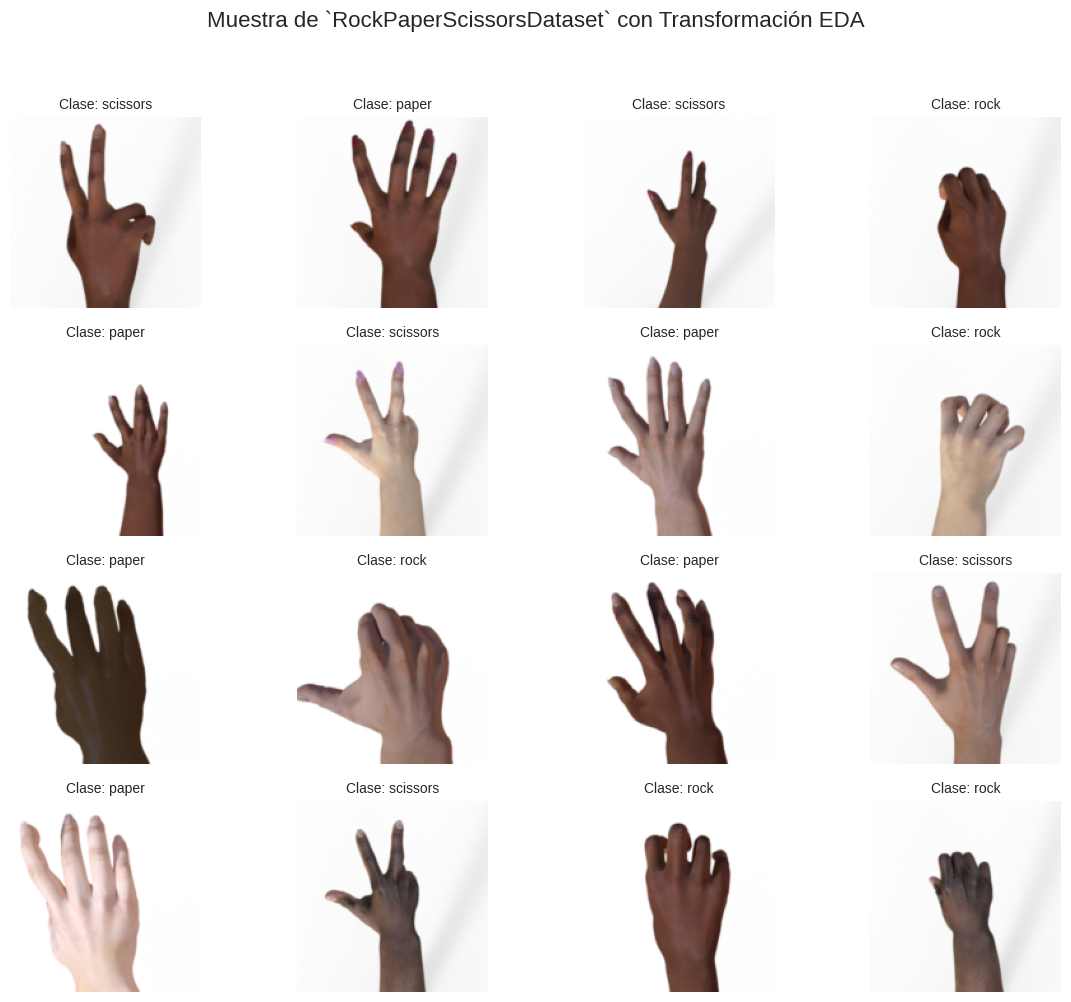


--- 3.2 Distribución de Clases ---
Conteo por clase: {'rock': 840, 'paper': 840, 'scissors': 840}


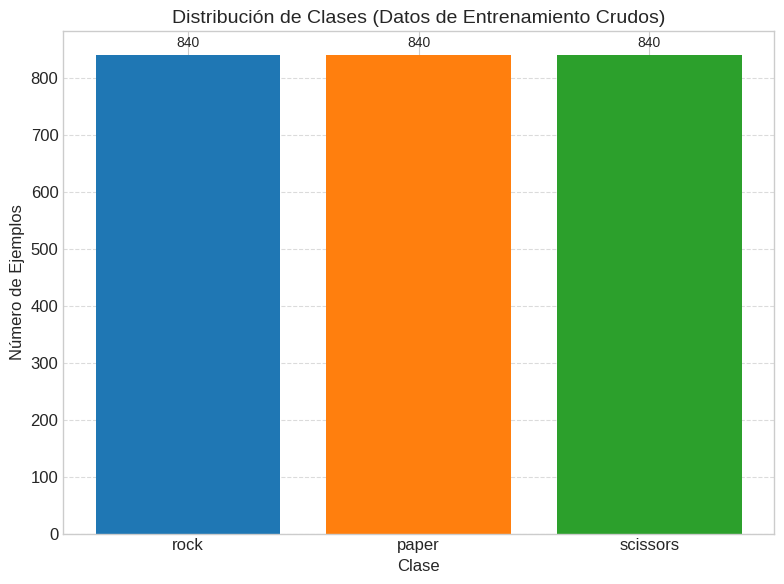


--- 3.3 Dimensiones y Tipo de Datos Originales ---
Forma original (TFDS): (300, 300, 3)
Tipo de datos original (TFDS): <dtype: 'uint8'>

--- 3.4 Histogramas de Intensidad de Píxeles (Imágenes Crudas NumPy) ---
Mostrando histogramas para 1 ejemplo por clase de `train_data_list` (imágenes crudas):

Histograma para Clase: scissors


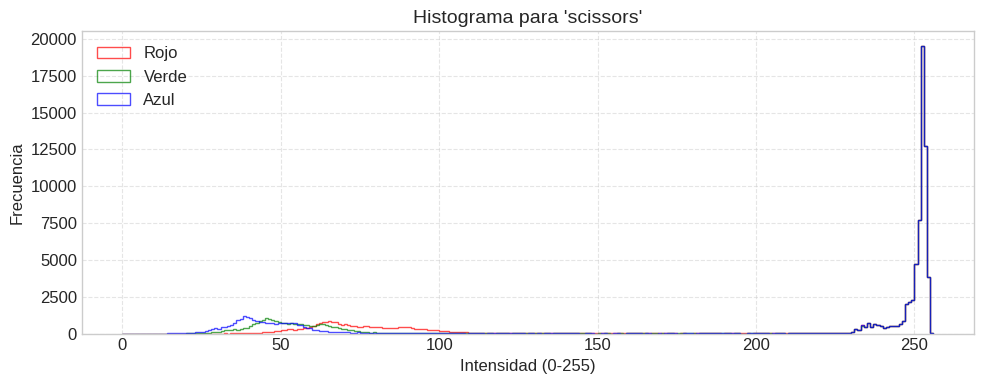


Histograma para Clase: rock


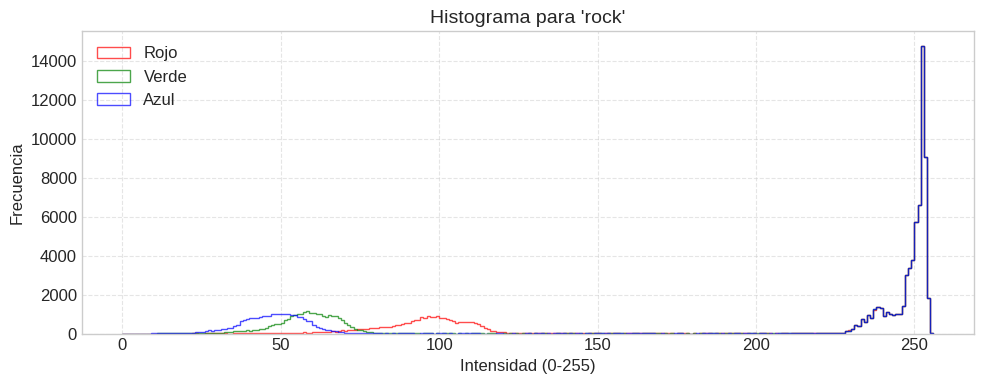


Histograma para Clase: paper


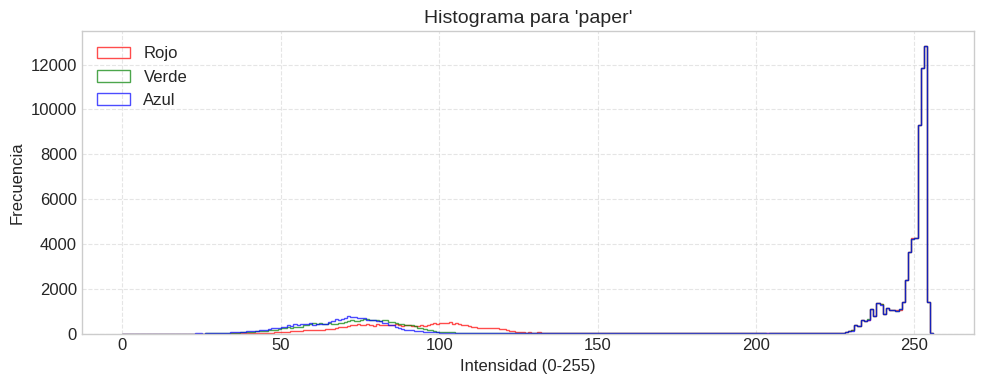


--- 3.5 Visualización Detallada por Clase (Imágenes Crudas de `train_data_list`) ---


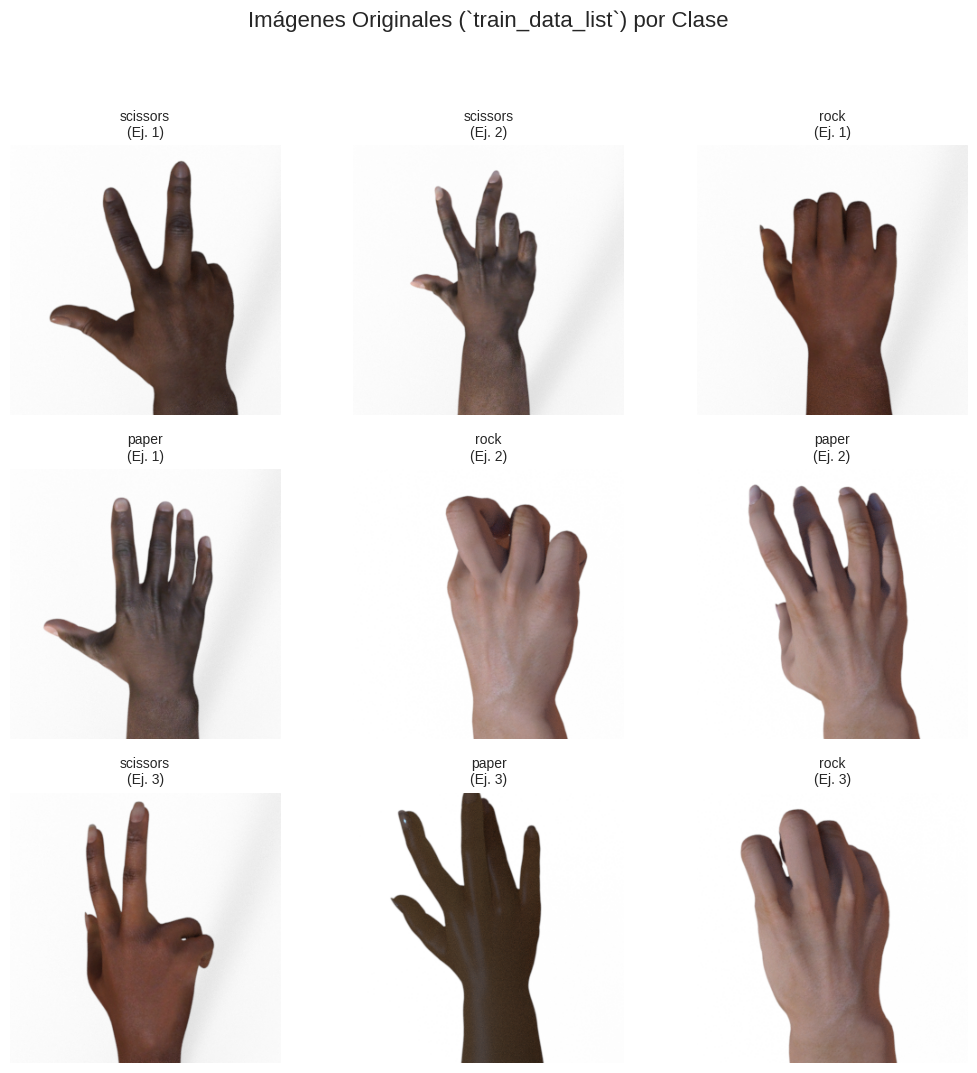


--- Fin de EDA ---


In [3]:
# 3. Visualización del Dataset y EDA
# ------------------------------------------------------------------------------

# Transformación básica solo para visualización EDA (Redimensionar, convertir a Tensor)
# No normalizamos aquí para ver los histogramas de píxeles en el rango original 0-255
# y para que imshow muestre correctamente imágenes uint8 si se convierten de nuevo.
transform_eda_viz = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.ToTensor() # Convierte PIL Image (H,W,C) o NumPy (H,W,C) a Tensor (C,H,W) y escala a [0,1]
])

# Crear una instancia del dataset para EDA (sin aumento, solo transformaciones básicas)
dataset_eda_pytorch = RockPaperScissorsDataset(train_data_list, transform=transform_eda_viz)
dataloader_eda_pytorch = DataLoader(dataset_eda_pytorch, batch_size=BATCH_SIZE, shuffle=True)

# 3.1 Visualización Inicial (imágenes después de transform_eda_viz)
# ------------------------------------------------------------------------------
print("\n--- 3.1 Visualización Inicial (Imágenes con Transformación EDA Básica) ---")
def mostrar_lote_imagenes_pytorch(dataloader, titulo_fig="Muestra de Imágenes (PyTorch)"):
    """Muestra un lote de imágenes de un DataLoader PyTorch."""
    images_batch, labels_batch = next(iter(dataloader)) # Obtener un lote

    plt.figure(figsize=(12, 10))
    plt.suptitle(titulo_fig, fontsize=16, y=1.0)
    for i in range(min(16, images_batch.size(0))):
        img_tensor = images_batch[i] # Tensor (C, H, W)
        # Para imshow, necesitamos (H, W, C) y preferiblemente NumPy
        img_display = img_tensor.permute(1, 2, 0).cpu().numpy() # Cambiar C,H,W a H,W,C
        # Si ToTensor escaló a [0,1], imshow lo maneja. Si fuera [-1,1] por normalización, se necesitaría desnormalizar.

        plt.subplot(4, 4, i + 1)
        plt.imshow(img_display)
        plt.title(f"Clase: {nombres_clases[labels_batch[i].item()]}", fontsize=10)
        plt.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

mostrar_lote_imagenes_pytorch(dataloader_eda_pytorch, "Muestra de `RockPaperScissorsDataset` con Transformación EDA")

# 3.2 Distribución de Clases
# ------------------------------------------------------------------------------
print("\n--- 3.2 Distribución de Clases ---")
counts_train_clases_pt = [0] * NUM_CLASSES
for _, label in train_data_list: # Iterar sobre la lista de datos crudos (NumPy)
    counts_train_clases_pt[label] += 1

print(f"Conteo por clase: {dict(zip(nombres_clases, counts_train_clases_pt))}")
plt.figure(figsize=(8, 6))
plt.bar(nombres_clases, counts_train_clases_pt, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Distribución de Clases (Datos de Entrenamiento Crudos)', fontsize=14)
# (Resto del código de ploteo de barras igual que en Keras)
plt.xlabel('Clase', fontsize=12); plt.ylabel('Número de Ejemplos', fontsize=12)
for i, count_val in enumerate(counts_train_clases_pt):
    plt.text(i, count_val + (max(counts_train_clases_pt) * 0.01), str(count_val), ha='center', va='bottom', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7); plt.tight_layout(); plt.show()

# 3.3 Dimensiones y Tipo de Datos Originales (de TFDS info)
# ------------------------------------------------------------------------------
print("\n--- 3.3 Dimensiones y Tipo de Datos Originales ---")
print(f"Forma original (TFDS): {ds_info_tfds.features['image'].shape}")
print(f"Tipo de datos original (TFDS): {ds_info_tfds.features['image'].dtype}")

# 3.4 Histogramas de Intensidad de Píxeles (de imágenes crudas NumPy)
# ------------------------------------------------------------------------------
print("\n--- 3.4 Histogramas de Intensidad de Píxeles (Imágenes Crudas NumPy) ---")
# Usamos la misma función `plot_histograma_pixel` de la versión Keras,
# ya que opera sobre arrays NumPy (H,W,C) uint8.
# La función plot_histograma_pixel fue definida en la Celda 6 de la versión Keras,
# la redefinimos aquí para que sea autocontenida.
def plot_histograma_pixel_pt(imagen_numpy_h_w_c, titulo_hist="Histograma de Intensidad de Píxeles"):
    """Espera un array NumPy (H,W,C) uint8."""
    plt.figure(figsize=(10, 4))
    colores_canal = ('red', 'green', 'blue')
    nombres_canal = ('Rojo', 'Verde', 'Azul')
    for i, color_c in enumerate(colores_canal):
        canal_pixeles = imagen_numpy_h_w_c[:, :, i].ravel()
        plt.hist(canal_pixeles, bins=256, range=[0,256], color=color_c, label=nombres_canal[i], alpha=0.7, histtype='step')
    plt.title(titulo_hist, fontsize=14); plt.xlabel("Intensidad (0-255)", fontsize=12); plt.ylabel("Frecuencia", fontsize=12)
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

print("Mostrando histogramas para 1 ejemplo por clase de `train_data_list` (imágenes crudas):")
muestras_hist_mostradas_pt = [0] * NUM_CLASSES
for img_np_raw, lbl_raw_val in train_data_list: # img_np_raw es (H,W,C) uint8
    if muestras_hist_mostradas_pt[lbl_raw_val] < 1:
        print(f"\nHistograma para Clase: {nombres_clases[lbl_raw_val]}")
        plot_histograma_pixel_pt(img_np_raw, f"Histograma para '{nombres_clases[lbl_raw_val]}'")
        muestras_hist_mostradas_pt[lbl_raw_val] += 1
    if all(c >= 1 for c in muestras_hist_mostradas_pt): break

# 3.5 Visualización Detallada por Clase (Imágenes Crudas NumPy)
# ------------------------------------------------------------------------------
print("\n--- 3.5 Visualización Detallada por Clase (Imágenes Crudas de `train_data_list`) ---")
num_ejemplos_clase_viz_raw_pt = 3
plt.figure(figsize=(num_ejemplos_clase_viz_raw_pt * 3.5, NUM_CLASSES * 3.5))
plt.suptitle("Imágenes Originales (`train_data_list`) por Clase", fontsize=16, y=1.02)
# (Lógica de ploteo similar a Keras, usando train_data_list)
muestras_clase_mostradas_pt_raw = [0] * NUM_CLASSES; idx_plot_pt_raw = 1
for img_r_pt, lbl_r_pt in train_data_list:
    if muestras_clase_mostradas_pt_raw[lbl_r_pt] < num_ejemplos_clase_viz_raw_pt:
        plt.subplot(NUM_CLASSES, num_ejemplos_clase_viz_raw_pt, idx_plot_pt_raw)
        plt.imshow(img_r_pt) # Directamente el NumPy array (H,W,C) uint8
        plt.title(f"{nombres_clases[lbl_r_pt]}\n(Ej. {muestras_clase_mostradas_pt_raw[lbl_r_pt]+1})", fontsize=10)
        plt.axis('off'); muestras_clase_mostradas_pt_raw[lbl_r_pt] += 1; idx_plot_pt_raw += 1
    if all(c >= num_ejemplos_clase_viz_raw_pt for c in muestras_clase_mostradas_pt_raw): break
plt.tight_layout(rect=[0,0,1,0.98]); plt.show()
print("\n--- Fin de EDA ---")

## **4. Definición de Transformaciones para Preprocesamiento y Aumento de Datos**

PyTorch utiliza `torchvision.transforms` para el preprocesamiento y aumento de datos.
Definiremos dos pipelines de transformación:
1.  **`transform_train`**: Para el conjunto de entrenamiento. Incluirá:
    * Redimensionamiento (`Resize`).
    * Aumento de datos (ej. `RandomHorizontalFlip`, `RandomRotation`).
    * Conversión a Tensor PyTorch (`ToTensor`): Esto también permuta las dimensiones de la imagen de (H, W, C) a (C, H, W) y escala los valores de píxeles de [0, 255] a [0.0, 1.0].
    * Normalización (`Normalize`): Estandariza los valores de los píxeles utilizando la media y desviación estándar de los canales (comúnmente las de ImageNet, o se pueden calcular del propio dataset).
2.  **`transform_test`**: Para el conjunto de prueba/validación. Incluirá solo:
    * Redimensionamiento (`Resize`).
    * Conversión a Tensor PyTorch (`ToTensor`).
    * Normalización (`Normalize`) con los mismos parámetros que el conjunto de entrenamiento.

**Nota sobre Normalización:** Los valores de media y desviación estándar (ej. `mean=[0.485, 0.456, 0.406]`, `std=[0.229, 0.224, 0.225]` para ImageNet) son importantes si se planea usar modelos pre-entrenados. Para un entrenamiento desde cero, se podrían calcular del propio dataset de entrenamiento o usar valores genéricos como `mean=[0.5, 0.5, 0.5]`, `std=[0.5, 0.5, 0.5]` para escalar a [-1, 1]. Aquí usaremos los de ImageNet por ser una práctica común.


Pipelines de transformación `transform_train` y `transform_test` definidos.

Visualizando efecto de `transform_train` en una imagen de muestra:


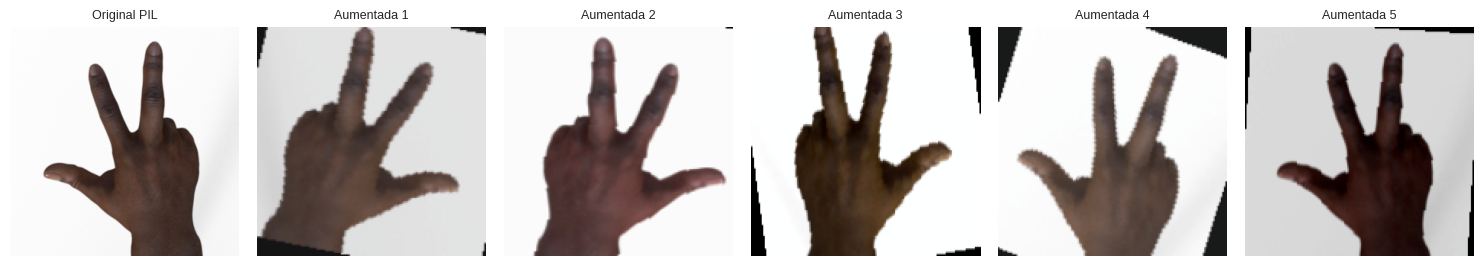

In [4]:
# 4. Definición de Transformaciones
# ------------------------------------------------------------------------------

# Parámetros de normalización (comunes de ImageNet)
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

# Transformaciones para el conjunto de ENTRENAMIENTO (con aumento de datos)
transform_train = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=20), # Rota entre -20 y +20 grados
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05), # Ligero ajuste de color
    T.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.8, 1.0)), # Zoom y recorte aleatorio
    T.ToTensor(), # Convierte PIL (H,W,C) [0-255] a Tensor (C,H,W) [0-1]
    T.Normalize(mean=normalize_mean, std=normalize_std)
])

# Transformaciones para el conjunto de PRUEBA/VALIDACIÓN (sin aumento de datos)
transform_test = T.Compose([
    T.Resize(IMAGE_SIZE), # Solo redimensionar
    T.ToTensor(),
    T.Normalize(mean=normalize_mean, std=normalize_std)
])

print("Pipelines de transformación `transform_train` y `transform_test` definidos.")

# Visualizar el efecto del aumento (opcional, pero bueno para verificar)
print("\nVisualizando efecto de `transform_train` en una imagen de muestra:")
img_pil_sample = Image.fromarray(train_data_list[0][0]) # Tomar la primera imagen cruda y convertir a PIL

plt.figure(figsize=(15, 4))
plt.subplot(1, 6, 1)
plt.imshow(img_pil_sample)
plt.title("Original PIL", fontsize=9); plt.axis('off')

for i in range(5):
    augmented_img_tensor = transform_train(img_pil_sample) # Aplicar transform_train
    # Desnormalizar y permutar para visualización si es necesario
    # Esta es una desnormalización aproximada para visualización
    img_display_aug = augmented_img_tensor.permute(1, 2, 0).cpu().numpy()
    img_display_aug = np.clip((img_display_aug * np.array(normalize_std)) + np.array(normalize_mean), 0, 1)

    plt.subplot(1, 6, i + 2)
    plt.imshow(img_display_aug)
    plt.title(f"Aumentada {i+1}", fontsize=9); plt.axis('off')
plt.tight_layout(); plt.show()

## **5. Creación de los `DataLoader` de PyTorch**

Con nuestro `RockPaperScissorsDataset` personalizado y las transformaciones definidas, ahora podemos crear las instancias de `Dataset` para entrenamiento y prueba, y luego envolverlas en `DataLoader`.

 * `train_dataset_final`: Instancia de `RockPaperScissorsDataset` usando `train_data_list` y `transform_train`.
 * `test_dataset_final`: Instancia de `RockPaperScissorsDataset` usando `test_data_list` y `transform_test`.

Los `DataLoader` se encargarán de crear lotes (batches), mezclar los datos (shuffle) para el entrenamiento, y cargar los datos eficientemente (posiblemente en paralelo usando `num_workers`).


In [5]:
# 5. Creación de los DataLoader
# ------------------------------------------------------------------------------

# Crear instancias finales de Dataset
train_dataset_final = RockPaperScissorsDataset(train_data_list, transform=transform_train)
test_dataset_final = RockPaperScissorsDataset(test_data_list, transform=transform_test)

print(f"Tamaño de train_dataset_final: {len(train_dataset_final)}")
print(f"Tamaño de test_dataset_final: {len(test_dataset_final)}")

# Crear DataLoaders
# num_workers > 0 puede acelerar la carga de datos si no hay cuellos de botella de CPU/IO.
# pin_memory=True puede acelerar transferencias a GPU.
num_cpu_cores = os.cpu_count()
workers = min(4, num_cpu_cores if num_cpu_cores is not None else 1) # Limitar a 4 o num cores

train_dataloader = DataLoader(
    train_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=True, # Mezclar para el entrenamiento
    num_workers=workers,
    pin_memory=True if device.type == 'cuda' else False
)

test_dataloader = DataLoader(
    test_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario mezclar para prueba/validación
    num_workers=workers,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nDataLoaders `train_dataloader` y `test_dataloader` creados.")
print(f"Número de lotes en train_dataloader: {len(train_dataloader)}")
print(f"Número de lotes en test_dataloader: {len(test_dataloader)}")

# Verificar un lote (opcional)
# images_check, labels_check = next(iter(train_dataloader))
# print(f"Forma del lote de imágenes de entrenamiento: {images_check.shape}") # Debería ser (BATCH_SIZE, C, H, W)
# print(f"Forma del lote de etiquetas de entrenamiento: {labels_check.shape}")


Tamaño de train_dataset_final: 2520
Tamaño de test_dataset_final: 372

DataLoaders `train_dataloader` y `test_dataloader` creados.
Número de lotes en train_dataloader: 79
Número de lotes en test_dataloader: 12


## **6. Definición de Modelos CNN en PyTorch**

Definiremos dos arquitecturas CNN como clases que heredan de `torch.nn.Module`.
PyTorch requiere que se defina el método `__init__` (donde se instancian las capas) y el método `forward` (que define cómo los datos fluyen a través de las capas).

 * **Modelo 1: CNN Sencilla**
 * **Modelo 2: CNN Mejorada** (con `BatchNorm2d` y `Dropout`)

Las capas convolucionales en PyTorch (`nn.Conv2d`) esperan una entrada de la forma `(N, C_in, H_in, W_in)`, donde N es el tamaño del lote.


In [6]:
# 6. Definición de Modelos CNN en PyTorch
# ------------------------------------------------------------------------------

class CNNSencilla(nn.Module):
    def __init__(self, num_clases, input_canales=3):
        super(CNNSencilla, self).__init__()
        # Formato PyTorch para Conv2d: (in_channels, out_channels, kernel_size, stride, padding)
        self.conv1 = nn.Conv2d(input_canales, 32, kernel_size=3, padding=1) # padding=1 para mantener tamaño con kernel 3
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Reduce dimensiones a la mitad

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calcular el tamaño aplanado después de las convoluciones y pooling
        # Asumiendo entrada IMG_HEIGHT x IMG_WIDTH (ej. 150x150)
        # Después de pool1: 150/2 = 75
        # Después de pool2: 75/2 = 37 (int(75/2))
        # Si IMG_HEIGHT o IMG_WIDTH no son divisibles, usar math.floor o ajustar padding
        h_out = IMG_HEIGHT // 4
        w_out = IMG_WIDTH // 4
        self.flattened_size = 64 * h_out * w_out # 64 canales de la última Conv

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.flattened_size, 128) # Capa densa
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_clases)
        # No es necesario Softmax aquí si se usa nn.CrossEntropyLoss, ya que lo incluye.

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNMejorada(nn.Module):
    def __init__(self, num_clases, input_canales=3):
        super(CNNMejorada, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(input_canales, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # Capa adicional
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        h_out = IMG_HEIGHT // 8 # 150 -> 75 -> 37 -> 18
        w_out = IMG_WIDTH // 8
        self.flattened_size_adv = 128 * h_out * w_out

        self.flatten = nn.Flatten()
        self.fc_block = nn.Sequential(
            nn.Linear(self.flattened_size_adv, 256),
            nn.BatchNorm1d(256), # BatchNorm para capas densas
            nn.ReLU(),
            nn.Dropout(p=0.5), # Dropout
            nn.Linear(256, num_clases)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc_block(x)
        return x

# Instanciar los modelos (sin moverlos a device aún, se hará en el bucle de ent.)
modelo_cnn_1_pt = CNNSencilla(num_clases=NUM_CLASSES, input_canales=INPUT_CHANNELS)
modelo_cnn_2_pt = CNNMejorada(num_clases=NUM_CLASSES, input_canales=INPUT_CHANNELS)

# Mostrar un resumen (PyTorch no tiene .summary() como Keras, pero podemos imprimir el modelo)
print("--- Modelo CNN Sencilla (PyTorch) ---")
print(modelo_cnn_1_pt)
# Para un resumen más detallado, se puede usar torchinfo.summary(model, input_size=(BATCH_SIZE, C, H, W))
# from torchinfo import summary
# summary(modelo_cnn_1_pt, input_size=(BATCH_SIZE, INPUT_CHANNELS, IMG_HEIGHT, IMG_WIDTH), device="cpu")


print("\n--- Modelo CNN Mejorado (PyTorch) ---")
print(modelo_cnn_2_pt)
# summary(modelo_cnn_2_pt, input_size=(BATCH_SIZE, INPUT_CHANNELS, IMG_HEIGHT, IMG_WIDTH), device="cpu")

--- Modelo CNN Sencilla (PyTorch) ---
CNNSencilla(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

--- Modelo CNN Mejorado (PyTorch) ---
CNNMejorada(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 6

## **7. Entrenamiento y Evaluación de los Modelos (PyTorch)**

El entrenamiento en PyTorch es más manual que en Keras. Implica:
1.  **Bucle de Épocas:** Iterar sobre el número deseado de épocas.
2.  **Bucle de Lotes (Batches):** Dentro de cada época, iterar sobre los lotes del `DataLoader`.
3.  **Movimiento a Dispositivo:** Mover los datos y el modelo al dispositivo (`device`) seleccionado (CPU o GPU).
4.  **Paso Adelante (Forward Pass):** `outputs = model(inputs)`.
5.  **Cálculo de Pérdida:** `loss = criterion(outputs, labels)`.
6.  **Paso Atrás (Backward Pass) y Optimización:**
    * `optimizer.zero_grad()` (limpiar gradientes acumulados).
    * `loss.backward()` (calcular gradientes).
    * `optimizer.step()` (actualizar pesos).
7.  **Métricas:** Calcular y acumular la pérdida y precisión.
8.  **Modo Evaluación:** Para la validación/prueba, cambiar el modelo a modo evaluación (`model.eval()`) y desactivar el cálculo de gradientes (`with torch.no_grad():`).

Definiremos una función de pérdida (`nn.CrossEntropyLoss`) y un optimizador (`optim.Adam`).
También crearemos funciones para el bucle de entrenamiento y el bucle de evaluación.



--- Entrenando y Evaluando: CNN Sencilla (PyTorch) en cuda ---
Iniciando Época 1/30
  Época [1/30], Lote [7/79], Pérdida Lote: 0.0684, Pérdida Época (avg): 0.1129, Acc Época (avg): 0.9866
  Época [1/30], Lote [14/79], Pérdida Lote: 0.0023, Pérdida Época (avg): 0.0713, Acc Época (avg): 0.9888
  Época [1/30], Lote [21/79], Pérdida Lote: 0.0009, Pérdida Época (avg): 0.0539, Acc Época (avg): 0.9881
  Época [1/30], Lote [28/79], Pérdida Lote: 0.0016, Pérdida Época (avg): 0.0478, Acc Época (avg): 0.9888
  Época [1/30], Lote [35/79], Pérdida Lote: 0.0018, Pérdida Época (avg): 0.0395, Acc Época (avg): 0.9911
  Época [1/30], Lote [42/79], Pérdida Lote: 0.1086, Pérdida Época (avg): 0.0362, Acc Época (avg): 0.9918
  Época [1/30], Lote [49/79], Pérdida Lote: 0.0031, Pérdida Época (avg): 0.0319, Acc Época (avg): 0.9930
  Época [1/30], Lote [56/79], Pérdida Lote: 0.0013, Pérdida Época (avg): 0.0290, Acc Época (avg): 0.9933
  Época [1/30], Lote [63/79], Pérdida Lote: 0.0005, Pérdida Época (avg): 0.0

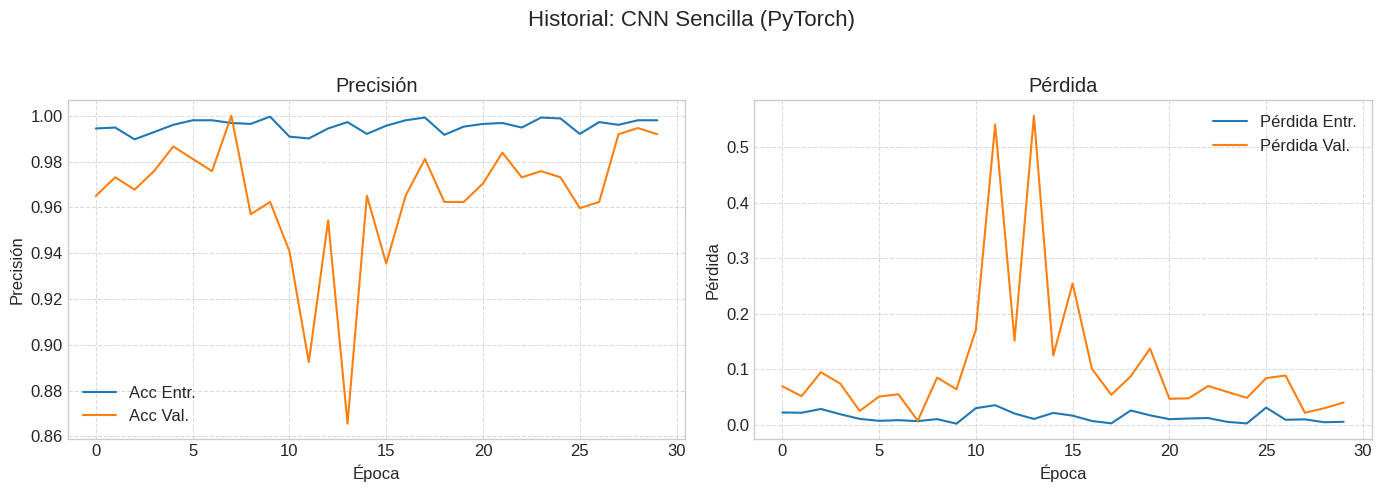


Mejor resultado para CNN Sencilla (PyTorch) en época 8: Acc Val = 1.0000, Pérdida Val = 0.0078

--- Entrenando y Evaluando: CNN Mejorada (PyTorch) en cuda ---
Iniciando Época 1/30
  Época [1/30], Lote [7/79], Pérdida Lote: 0.0034, Pérdida Época (avg): 0.0038, Acc Época (avg): 1.0000
  Época [1/30], Lote [14/79], Pérdida Lote: 0.0280, Pérdida Época (avg): 0.0313, Acc Época (avg): 0.9888
  Época [1/30], Lote [21/79], Pérdida Lote: 0.0455, Pérdida Época (avg): 0.0402, Acc Época (avg): 0.9851
  Época [1/30], Lote [28/79], Pérdida Lote: 0.0010, Pérdida Época (avg): 0.0420, Acc Época (avg): 0.9855
  Época [1/30], Lote [35/79], Pérdida Lote: 0.0277, Pérdida Época (avg): 0.0441, Acc Época (avg): 0.9848
  Época [1/30], Lote [42/79], Pérdida Lote: 0.0062, Pérdida Época (avg): 0.0397, Acc Época (avg): 0.9859
  Época [1/30], Lote [49/79], Pérdida Lote: 0.0103, Pérdida Época (avg): 0.0370, Acc Época (avg): 0.9866
  Época [1/30], Lote [56/79], Pérdida Lote: 0.0015, Pérdida Época (avg): 0.0380, Acc 

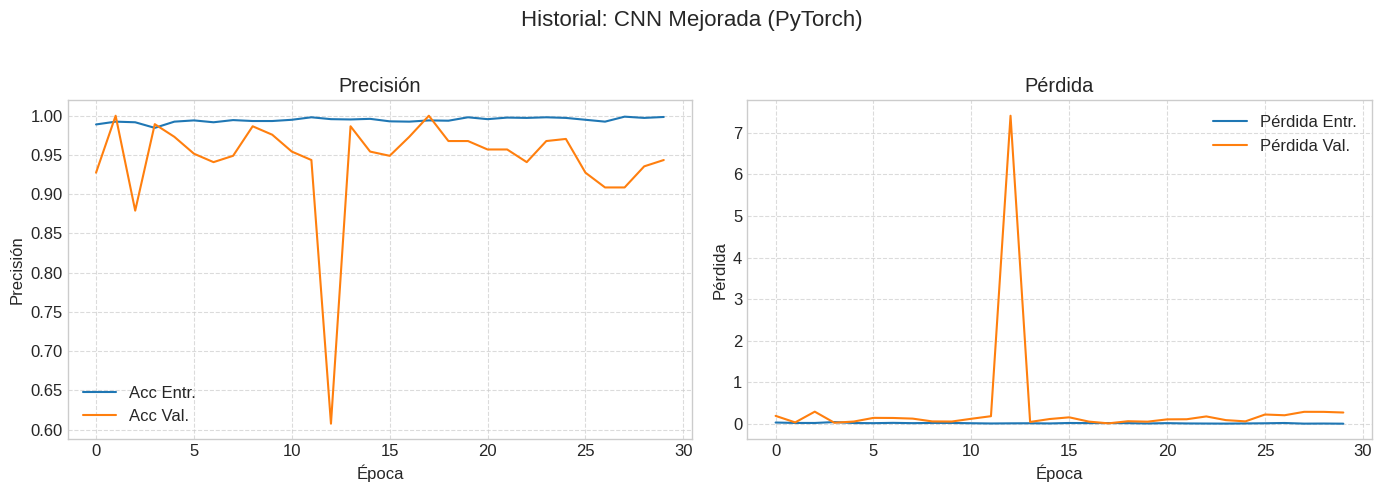


Mejor resultado para CNN Mejorada (PyTorch) en época 2: Acc Val = 1.0000, Pérdida Val = 0.0345

--- Resumen de Resultados (PyTorch) ---
CNN Sencilla: Mejor Precisión en Validación = 100.00%, Pérdida = 0.0078
CNN Mejorada: Mejor Precisión en Validación = 100.00%, Pérdida = 0.0345

El mejor modelo (PyTorch) es: CNN Mejorada (PyTorch) con precisión 100.00%


In [10]:
# 7. Entrenamiento y Evaluación de los Modelos (PyTorch)
# ------------------------------------------------------------------------------

# Definir función de pérdida y optimizador (se instanciarán por modelo)
criterion = nn.CrossEntropyLoss() # Combina LogSoftmax y NLLLoss

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch_num, total_epochs):
    """Realiza una época de entrenamiento."""
    model.train() # Poner el modelo en modo entrenamiento
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    print_interval = max(1, len(dataloader) // 10) # Imprimir progreso ~10 veces por época

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()       # Limpiar gradientes
        outputs = model(inputs)     # Forward pass
        loss = criterion(outputs, labels) # Calcular pérdida
        loss.backward()             # Backward pass
        optimizer.step()            # Actualizar pesos

        running_loss += loss.item() * inputs.size(0)
        _, predicted_classes = torch.max(outputs, 1) # Obtener la clase con mayor probabilidad
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

        if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == len(dataloader):
            current_loss = running_loss / total_samples
            current_acc = correct_predictions / total_samples
            print(f"  Época [{epoch_num+1}/{total_epochs}], Lote [{batch_idx+1}/{len(dataloader)}], Pérdida Lote: {loss.item():.4f}, Pérdida Época (avg): {current_loss:.4f}, Acc Época (avg): {current_acc:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def evaluate_model_pytorch(model, dataloader, criterion, device):
    """Evalúa el modelo en un conjunto de datos."""
    model.eval() # Poner el modelo en modo evaluación
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # No calcular gradientes durante la evaluación
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

    eval_loss = running_loss / total_samples
    eval_acc = correct_predictions / total_samples
    return eval_loss, eval_acc

def entrenar_y_evaluar_pytorch(modelo_pt, train_dl, test_dl, criterio_loss, optimizador_pt, num_epochs, nombre_modelo_str, dev):
    """Bucle principal de entrenamiento y evaluación para un modelo PyTorch."""
    print(f"\n--- Entrenando y Evaluando: {nombre_modelo_str} en {dev} ---")
    modelo_pt.to(dev) # Mover modelo al dispositivo

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_epoch_info = {} # Para guardar el estado del mejor modelo (opcional, early stopping manual)

    for epoch in range(num_epochs):
        print(f"Iniciando Época {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_one_epoch(modelo_pt, train_dl, criterio_loss, optimizador_pt, dev, epoch, num_epochs)
        val_loss, val_acc = evaluate_model_pytorch(modelo_pt, test_dl, criterio_loss, dev)

        print(f"FIN ÉPOCA {epoch+1}/{num_epochs}: "
              f"Pérdida Entr: {train_loss:.4f}, Acc Entr: {train_acc:.4f} | "
              f"Pérdida Val: {val_loss:.4f}, Acc Val: {val_acc:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Guardar el mejor modelo (simple early stopping basado en val_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch_info = {'epoch': epoch + 1, 'val_acc': val_acc, 'val_loss': val_loss}
            # torch.save(modelo_pt.state_dict(), f'{nombre_modelo_str}_best.pth') # Opcional: guardar aquí
            print(f"  Nueva mejor Acc Validación: {best_val_acc:.4f} (guardado provisionalmente)")

    # Graficar historial
    plt.figure(figsize=(14, 5)); plt.suptitle(f"Historial: {nombre_modelo_str}", fontsize=16)
    plt.subplot(1, 2, 1); plt.plot(history['train_acc'], label='Acc Entr.'); plt.plot(history['val_acc'], label='Acc Val.')
    plt.xlabel('Época'); plt.ylabel('Precisión'); plt.legend(); plt.title('Precisión'); plt.grid(True, linestyle='--', alpha=0.7)
    plt.subplot(1, 2, 2); plt.plot(history['train_loss'], label='Pérdida Entr.'); plt.plot(history['val_loss'], label='Pérdida Val.')
    plt.xlabel('Época'); plt.ylabel('Pérdida'); plt.legend(); plt.title('Pérdida'); plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

    print(f"\nMejor resultado para {nombre_modelo_str} en época {best_epoch_info.get('epoch', 'N/A')}: "
          f"Acc Val = {best_epoch_info.get('val_acc', 0.0):.4f}, Pérdida Val = {best_epoch_info.get('val_loss', float('inf')):.4f}")

    return modelo_pt, history, best_epoch_info.get('val_acc', 0.0), best_epoch_info.get('val_loss', float('inf'))


EPOCHS_PT = 30 # Reducir para ejecución de ejemplo. Aumentar para mejores resultados.
LEARNING_RATE_PT = 0.001

# Entrenar Modelo 1: CNN Sencilla (PyTorch)
optimizer_1_pt = optim.Adam(modelo_cnn_1_pt.parameters(), lr=LEARNING_RATE_PT)
modelo_cnn_1_pt, hist_1_pt, acc_1_pt, loss_1_pt = entrenar_y_evaluar_pytorch(
    modelo_cnn_1_pt, train_dataloader, test_dataloader, criterion, optimizer_1_pt,
    EPOCHS_PT, "CNN Sencilla (PyTorch)", device
)

# Entrenar Modelo 2: CNN Mejorada (PyTorch)
optimizer_2_pt = optim.Adam(modelo_cnn_2_pt.parameters(), lr=LEARNING_RATE_PT)
modelo_cnn_2_pt, hist_2_pt, acc_2_pt, loss_2_pt = entrenar_y_evaluar_pytorch(
    modelo_cnn_2_pt, train_dataloader, test_dataloader, criterion, optimizer_2_pt,
    EPOCHS_PT, "CNN Mejorada (PyTorch)", device
)

print("\n--- Resumen de Resultados (PyTorch) ---")
print(f"CNN Sencilla: Mejor Precisión en Validación = {acc_1_pt*100:.2f}%, Pérdida = {loss_1_pt:.4f}")
print(f"CNN Mejorada: Mejor Precisión en Validación = {acc_2_pt*100:.2f}%, Pérdida = {loss_2_pt:.4f}")

# Seleccionar el mejor modelo
mejor_modelo_pt = modelo_cnn_1_pt if acc_1_pt > acc_2_pt else modelo_cnn_2_pt
nombre_mejor_modelo_pt = "CNN Sencilla (PyTorch)" if acc_1_pt > acc_2_pt else "CNN Mejorada (PyTorch)"
acc_mejor_modelo_pt = max(acc_1_pt, acc_2_pt)
print(f"\nEl mejor modelo (PyTorch) es: {nombre_mejor_modelo_pt} con precisión {acc_mejor_modelo_pt*100:.2f}%")

## **8. Inferencia con el Mejor Modelo (PyTorch)**

Usaremos el mejor modelo entrenado para realizar predicciones en algunas imágenes del conjunto de prueba.
Es importante poner el modelo en modo `model.eval()` y usar `with torch.no_grad():` para la inferencia.
Las imágenes de entrada deben pasar por las mismas transformaciones (`transform_test`) que se usaron durante la evaluación.


Inferencia Usando el modelo: CNN Mejorada (PyTorch)


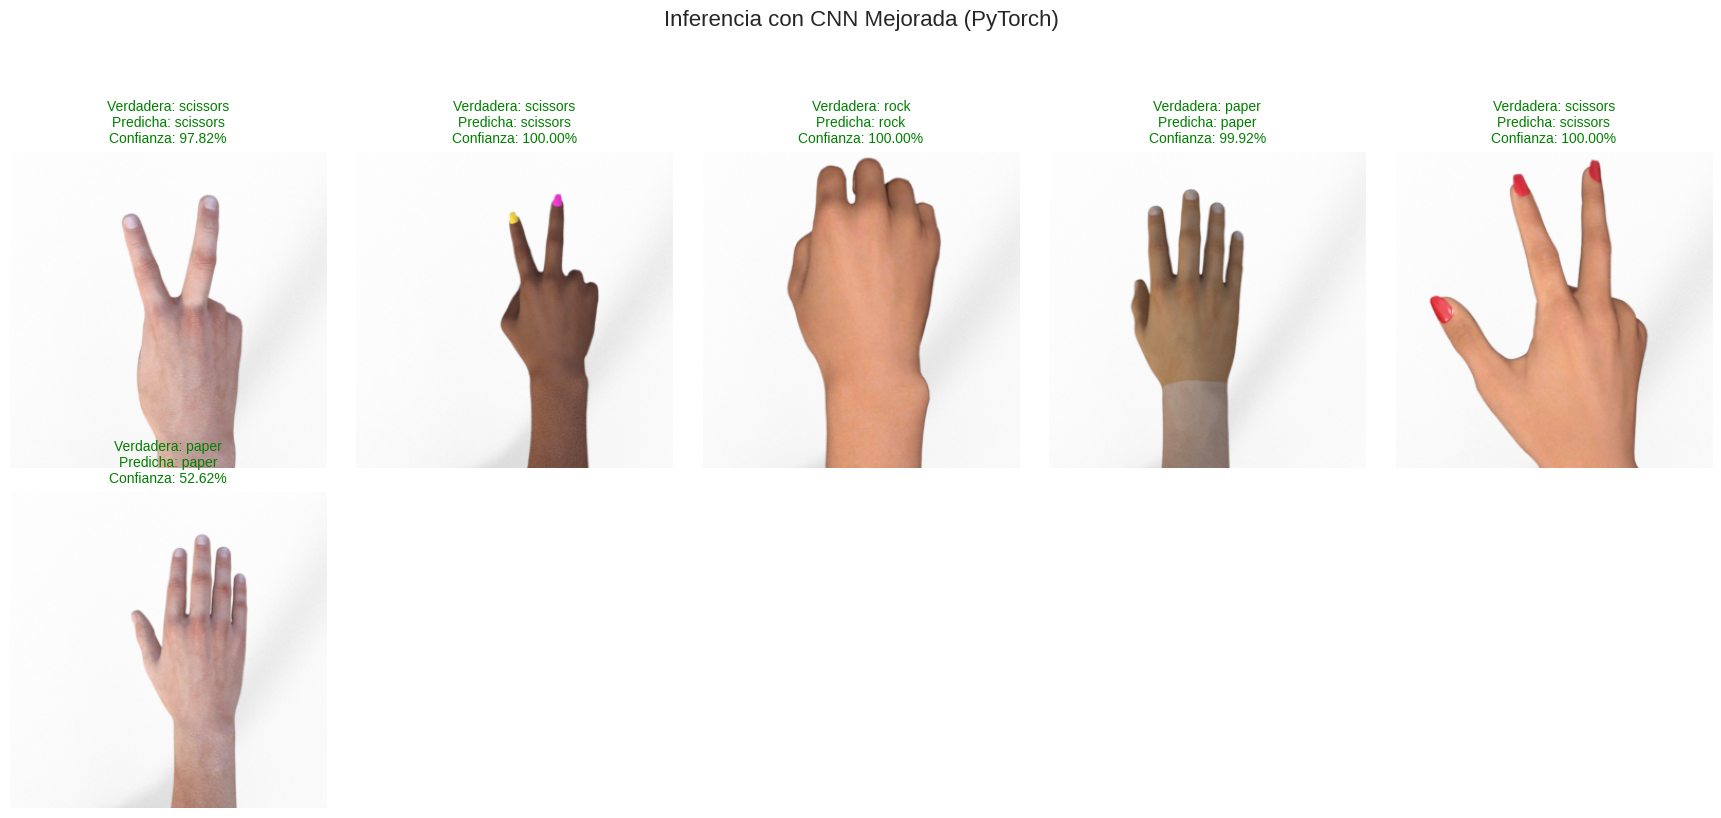

In [11]:
# 8. Inferencia con el Mejor Modelo (PyTorch)
# ------------------------------------------------------------------------------
print(f"Inferencia Usando el modelo: {nombre_mejor_modelo_pt}")
mejor_modelo_pt.eval() # Poner en modo evaluación

def realizar_inferencia_pytorch(modelo, data_lista_cruda, transform_aplicar, num_imgs, dev):
    """Realiza inferencia y muestra resultados para PyTorch."""
    modelo.to(dev) # Asegurar que el modelo está en el dispositivo correcto

    num_columnas_plot = min(num_imgs, 5) # Mostrar hasta 5 imágenes por fila
    num_filas_plot = (num_imgs + num_columnas_plot - 1) // num_columnas_plot

    plt.figure(figsize=(num_columnas_plot * 3.5, num_filas_plot * 4))
    plt.suptitle(f"Inferencia con {nombre_mejor_modelo_pt}", fontsize=16, y=1.02)

    for i in range(num_imgs):
        idx_muestra = np.random.randint(0, len(data_lista_cruda)) # Tomar una muestra aleatoria
        img_np_raw_inf, lbl_raw_inf = data_lista_cruda[idx_muestra]
        img_pil_inf = Image.fromarray(img_np_raw_inf) # Convertir a PIL para transformaciones

        # Aplicar transformaciones de prueba
        img_tensor_inf = transform_aplicar(img_pil_inf).unsqueeze(0).to(dev) # Añadir lote y mover a device
                                                                        # unsqueeze(0) -> (1, C, H, W)
        with torch.no_grad():
            outputs_inf = modelo(img_tensor_inf)
            probs_inf = torch.softmax(outputs_inf, dim=1)[0] # Softmax y tomar el primer (único) elemento
            clase_predicha_idx_inf = torch.argmax(probs_inf).item()
            confianza_pred_inf = probs_inf[clase_predicha_idx_inf].item()

        etiqueta_verdadera_str_inf = nombres_clases[lbl_raw_inf]
        etiqueta_predicha_str_inf = nombres_clases[clase_predicha_idx_inf]

        plt.subplot(num_filas_plot, num_columnas_plot, i + 1)
        plt.imshow(img_np_raw_inf) # Mostrar la imagen original cruda
        titulo_inf_pt = (f"Verdadera: {etiqueta_verdadera_str_inf}\n"
                         f"Predicha: {etiqueta_predicha_str_inf}\n"
                         f"Confianza: {confianza_pred_inf:.2%}")
        color_titulo_inf = 'green' if etiqueta_verdadera_str_inf == etiqueta_predicha_str_inf else 'red'
        plt.title(titulo_inf_pt, fontsize=10, color=color_titulo_inf)
        plt.axis('off')

    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# Realizar inferencia en algunas imágenes de `test_data_list` (que son datos crudos)
realizar_inferencia_pytorch(mejor_modelo_pt, test_data_list, transform_test, num_imgs=NUM_CLASSES * 2, dev=device)

## **9. Guardar el Mejor Modelo (PyTorch)**

En PyTorch, la forma más común de guardar un modelo es guardando su `state_dict` (diccionario de estado), que contiene los pesos y biases aprendidos.

Para cargar el modelo, se necesita recrear primero la instancia de la clase del modelo y luego cargar el `state_dict`.


In [12]:
# 9. Guardar el Mejor Modelo (PyTorch)
# ------------------------------------------------------------------------------

modelos_guardados_dir_pt = "modelos_pytorch_guardados"
if not os.path.exists(modelos_guardados_dir_pt):
    os.makedirs(modelos_guardados_dir_pt)

timestamp_pt = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Limpiar el nombre del modelo para nombres de archivo
nombre_archivo_limpio_pt = nombre_mejor_modelo_pt.replace(" (PyTorch)", "").replace(" ", "_")
nombre_archivo_modelo_pt = f"{nombre_archivo_limpio_pt}_{timestamp_pt}.pth" # .pth o .pt son comunes
ruta_guardado_modelo_pt = os.path.join(modelos_guardados_dir_pt, nombre_archivo_modelo_pt)

print(f"Guardando el state_dict del mejor modelo ({nombre_mejor_modelo_pt}) en: {ruta_guardado_modelo_pt}")
torch.save(mejor_modelo_pt.state_dict(), ruta_guardado_modelo_pt)
print("State_dict del modelo guardado exitosamente.")

# Ejemplo de cómo cargar el modelo posteriormente:
# print("\nEjemplo de cómo cargar el modelo (comentado):")
# if nombre_mejor_modelo_pt == "CNN Sencilla (PyTorch)":
#     modelo_cargado_pt = CNNSencilla(num_clases=NUM_CLASSES, input_canales=INPUT_CHANNELS)
# else:
#     modelo_cargado_pt = CNNMejorada(num_clases=NUM_CLASSES, input_canales=INPUT_CHANNELS)
#
# modelo_cargado_pt.load_state_dict(torch.load(ruta_guardado_modelo_pt, map_location=device)) # map_location para cargar en el dispositivo correcto
# modelo_cargado_pt.to(device) # Mover al dispositivo
# modelo_cargado_pt.eval() # Poner en modo evaluación
# print(f"Modelo '{nombre_mejor_modelo_pt}' cargado y listo para inferencia en {device}.")


Guardando el state_dict del mejor modelo (CNN Mejorada (PyTorch)) en: modelos_pytorch_guardados/CNN_Mejorada_20250507-191034.pth
State_dict del modelo guardado exitosamente.


## **Conclusiones y Próximos Pasos (PyTorch)**

En este notebook, hemos adaptado el ciclo completo de desarrollo de un modelo de clasificación de imágenes a PyTorch:
1.  Cargamos el dataset "Piedra, Papel o Tijeras" (vía TFDS) y lo preparamos para PyTorch con un `Dataset` personalizado.
2.  Realizamos un EDA similar, adaptando la visualización.
3.  Definimos transformaciones para preprocesamiento y aumento de datos usando `torchvision.transforms`.
4.  Creamos `DataLoader` para manejar los lotes de datos.
5.  Definimos dos arquitecturas CNN como clases `nn.Module`.
6.  Implementamos bucles de entrenamiento y evaluación manuales.
7.  Realizamos inferencias con el mejor modelo.
8.  Guardamos el `state_dict` del mejor modelo.

 **Comparación y Próximos Pasos:**
 * **PyTorch vs Keras:** Notarás que PyTorch ofrece un control más granular sobre el bucle de entrenamiento, mientras que Keras abstrae mucho de esto con `.fit()`.
 * **Transfer Learning:** Adaptar modelos pre-entrenados de `torchvision.models` (ej. ResNet, VGG) es un excelente siguiente paso.
 * **Hiperparámetros:** Experimentar con diferentes optimizadores, tasas de aprendizaje, planificadores de tasa de aprendizaje (`lr_scheduler`), y arquitecturas.
 * **Callbacks:** PyTorch no tiene un sistema de callbacks tan integrado como Keras. Se pueden implementar manualmente o usar librerías como PyTorch Lightning o fastai que ofrecen estas abstracciones.
